In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D,MaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
import pickle
from PIL import Image
import time
import os
from PIL import Image
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

In [2]:
dim = (176,208)
test_split_percent = .1
validation_split_percent = .2
zoom = [.99,1.01]
bright_range = [.8,1.2]
layers_unlocked = True
lr = 0.0001
batch = 20
eps = 20
momentum = .9
save_model_name = "val%2d_epochs%d"%(validation_split_percent*100,eps)
print(save_model_name)

val20_epochs20


In [4]:
train_dr =tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,brightness_range=bright_range,zoom_range=zoom,data_format='channels_last',zca_whitening=False)
train_data_gen =train_dr.flow_from_directory(directory="train",target_size=dim, batch_size=5000)

Found 5121 images belonging to 4 classes.


In [5]:
test_dr =tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,zoom_range=[1,1],data_format='channels_last')
test_data_gen =test_dr.flow_from_directory(directory="test",target_size=dim,batch_size=5000, shuffle = False)

Found 1279 images belonging to 4 classes.


In [6]:
#iteration for every label in the dataset
train_data,train_labels = next(train_data_gen)
test_data,test_labels = next(test_data_gen)

In [7]:
def visualize(direction):
  list_dir=os.listdir(direction)
  plt.figure(figsize=(14,8))
  for i in range(1,7):
    plt.subplot(2,3,i)
    img= plt.imread(os.path.join(direction,list_dir[i]))
    plt.imshow(img,cmap='gray')
    plt.axis('off')
  plt.tight_layout()

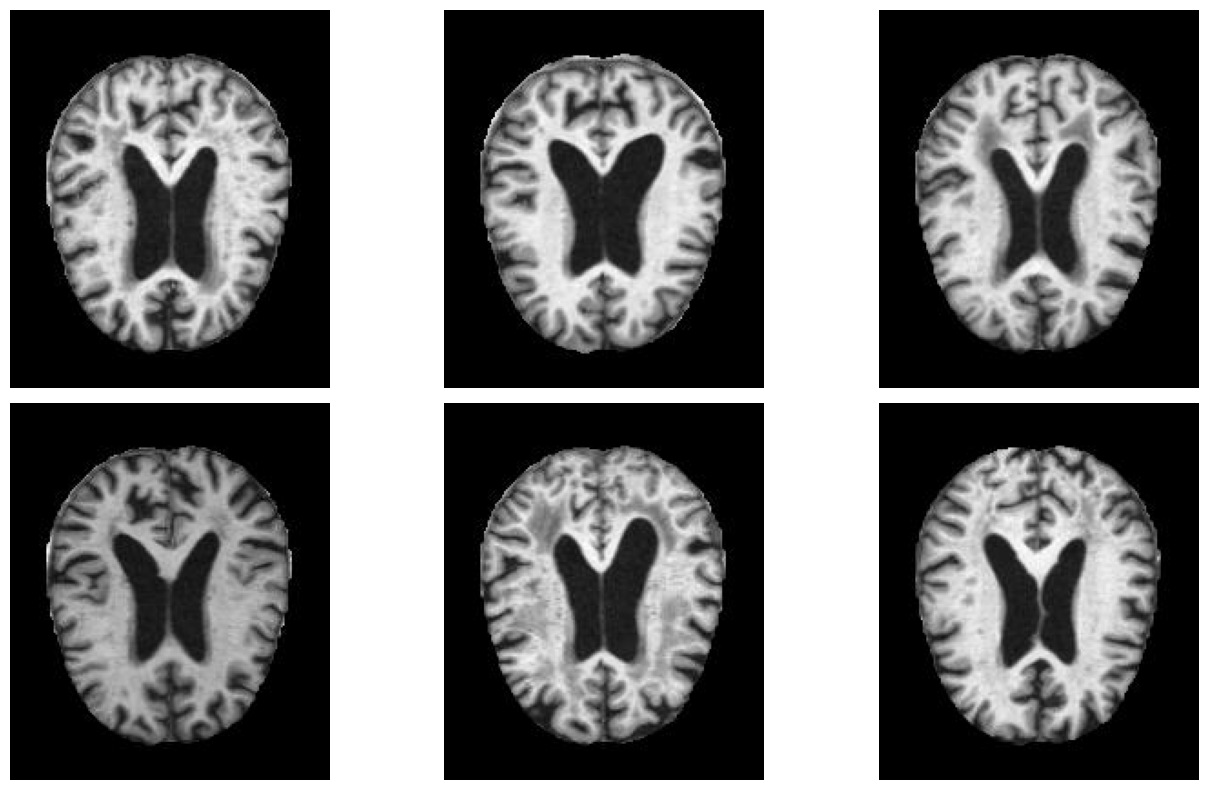

In [8]:
MildDemented_dir = 'test/MildDemented'
visualize(MildDemented_dir)    #example visualising for mild dementia

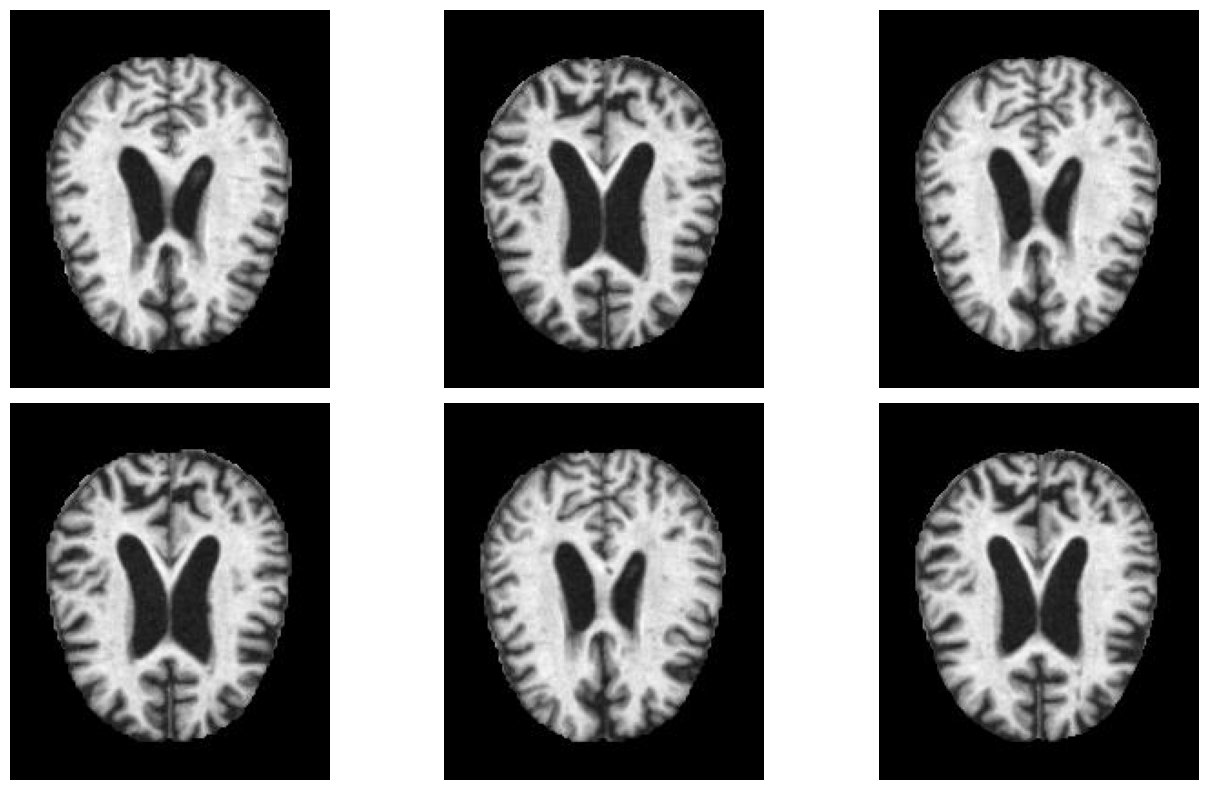

In [9]:
ModerateDemented_dir = 'test/ModerateDemented'
visualize(ModerateDemented_dir)    #example visualising for moderate dementia

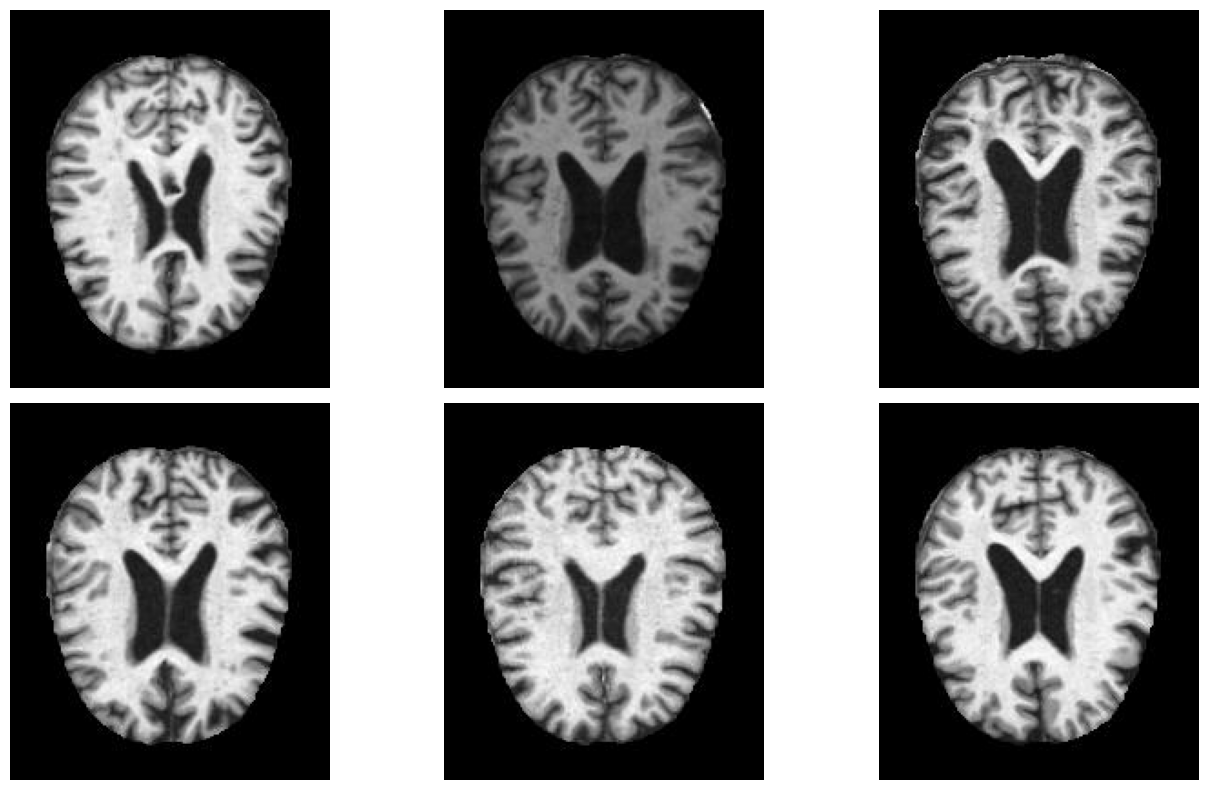

In [10]:
VeryMildDemented_dir = 'test/VeryMildDemented'
visualize(VeryMildDemented_dir)    #example visualising for very mild dementia

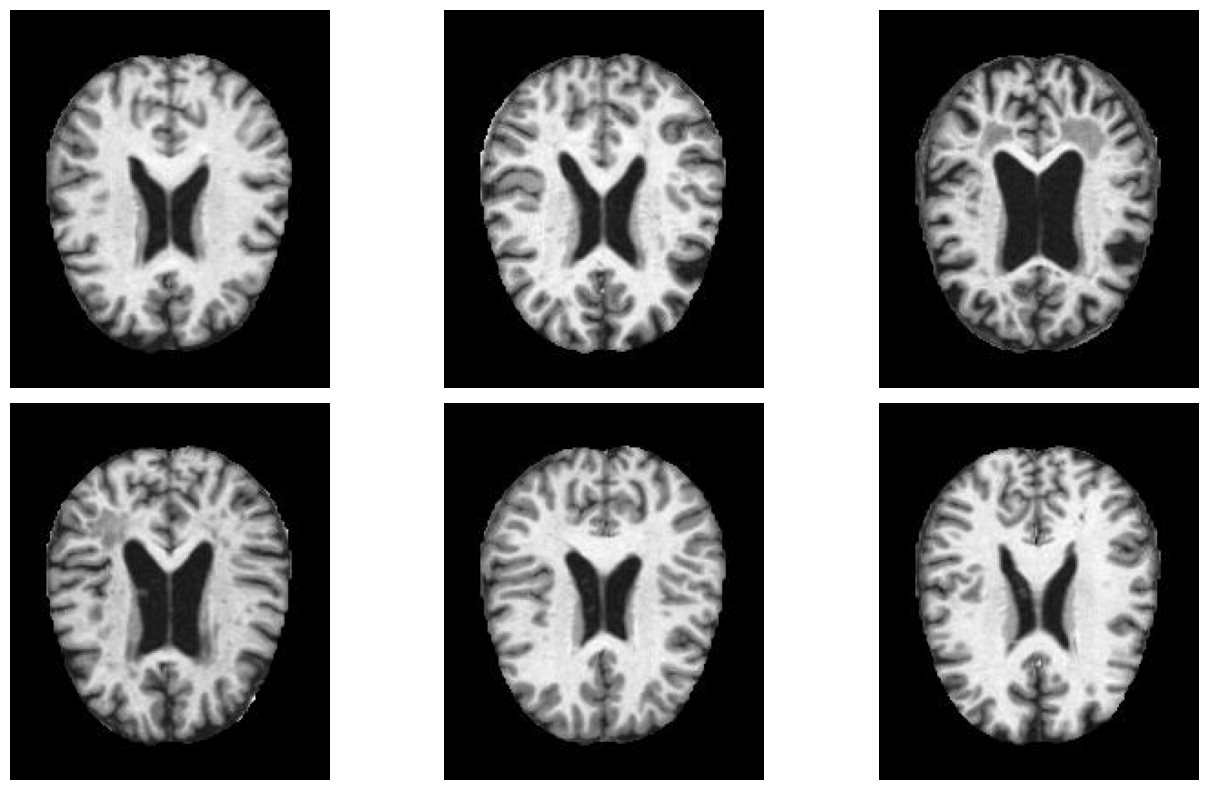

In [11]:
NonDemented_dir = 'test/NonDemented'
visualize(NonDemented_dir)    #example visualising for No dementia

In [12]:
total_data = np.concatenate((train_data,test_data))
total_labels = np.concatenate((train_labels,test_labels))
print(total_data.shape)
print(total_labels.shape)

(6279, 176, 208, 3)
(6279, 4)


In [13]:
initial_split = test_split_percent+validation_split_percent
test_val_split = test_split_percent/initial_split
train_data, test_val_data, train_labels, test_val_labels =train_test_split(total_data,total_labels,test_size=initial_split)
test_data, val_data, test_labels, val_labels =train_test_split(test_val_data,test_val_labels,test_size=test_val_split)

In [14]:
print('train: ',train_data.shape)
print('validation',val_data.shape)
print('test',test_data.shape)

train:  (4395, 176, 208, 3)
validation (628, 176, 208, 3)
test (1256, 176, 208, 3)


In [15]:
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(4395, 176, 208, 3)
(4395, 4)
(628, 176, 208, 3)
(628, 4)
(1256, 176, 208, 3)
(1256, 4)


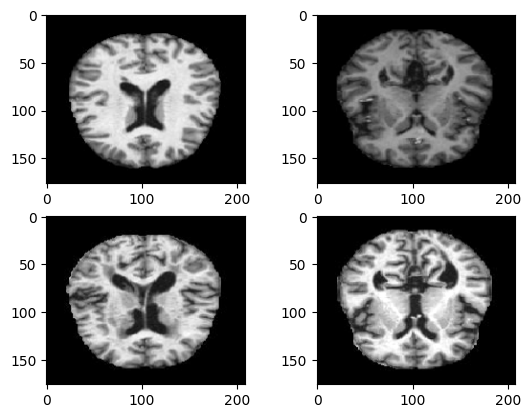

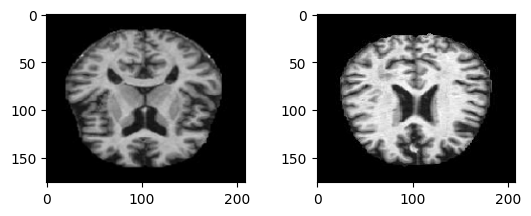

In [16]:
plt.subplot(221)                  #differnt classes of images are plotted
plt.imshow(train_data[1,:,:,:])
plt.subplot(222)
plt.imshow(train_data[2,:,:,:])
plt.subplot(223)
plt.imshow(val_data[3,:,:,:])
plt.subplot(224)
plt.imshow(val_data[4,:,:,:])
plt.show()
plt.subplot(221)
plt.imshow(test_data[5,:,:,:])
plt.subplot(222)
plt.imshow(test_data[154,:,:,:])

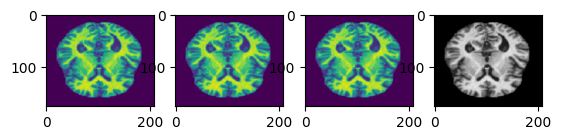

In [17]:
plt.subplot(141)
plt.imshow(train_data[3,:,:,0])
plt.subplot(142)
plt.imshow(train_data[3,:,:,1])
plt.subplot(143)
plt.imshow(train_data[3,:,:,2])
plt.subplot(144)
plt.imshow(train_data[3,:,:,:])

### VGG MODEL

In [18]:
vg_model =tf.keras.applications.vgg16.VGG16(include_top=False,input_shape=(dim[0],dim[1],3), pooling ='max')

In [19]:
vg_model.get_layer('block1_conv1').trainable = layers_unlocked
vg_model.get_layer('block1_conv2').trainable = layers_unlocked
vg_model.get_layer('block2_conv1').trainable = layers_unlocked
vg_model.get_layer('block2_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv1').trainable = layers_unlocked
vg_model.get_layer('block3_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv3').trainable = layers_unlocked
vg_model.get_layer('block4_conv1').trainable = layers_unlocked
vg_model.get_layer('block4_conv2').trainable = layers_unlocked
vg_model.get_layer('block4_conv3').trainable = layers_unlocked
flat = Flatten()(vg_model.output)
fc1 = Dense(1024,activation='relu', kernel_initializer='he_uniform')(flat)
dp1 = Dropout(0.25)(fc1)
output = Dense(4,activation='softmax')(dp1)
vg_model = Model(inputs=vg_model.inputs, outputs=output)
vg_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 176, 208, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 176, 208, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 176, 208, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 88, 104, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 88, 104, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 88, 104, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 44, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 44, 52, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 44, 52, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 44, 52, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 26, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 26, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 26, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 26, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 13, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 13, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 13, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 13, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 15,244,100 (58.15 MB)

 Trainable params: 15,244,100 (58.15 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
from tensorflow.keras.models import load_model
vg_model = load_model("VGG.hdf5",compile=False)

In [30]:
vg_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [31]:
# Evaluate the model on test data
test_loss, test_accuracy = vg_model.evaluate(val_data, val_labels)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - accuracy: 0.9878 - loss: 0.0701
Test Loss: 0.04895980656147003
Test Accuracy: 0.9904458522796631


In [32]:
train_scores = vg_model.evaluate(train_data, train_labels)
val_scores = vg_model.evaluate(val_data,val_labels)
test_scores = vg_model.evaluate(test_data, test_labels)

138/138 ━━━━━━━━━━━━━━━━━━━━ 561s 4s/step - accuracy: 0.9808 - loss: 0.0529
20/20 ━━━━━━━━━━━━━━━━━━━━ 77s 4s/step - accuracy: 0.9878 - loss: 0.0701
40/40 ━━━━━━━━━━━━━━━━━━━━ 155s 4s/step - accuracy: 0.9909 - loss: 0.0325


In [33]:
print('Train Accuracy: %.2f%%'%(train_scores[1]*100))
print('Validation Accuracy: %.2f%%'%(val_scores[1]*100))
print('Test Accuracy: %.2f%%'%(test_scores[1]*100))

Train Accuracy: 98.50%
Validation Accuracy: 99.04%
Test Accuracy: 98.65%


In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
predic = vg_model.predict(test_data)
predic = np.argmax(predic, axis=1)
labels = np.argmax(test_labels, axis=1)

40/40 ━━━━━━━━━━━━━━━━━━━━ 159s 4s/step


In [36]:
conf_arr = confusion_matrix(labels, predic)

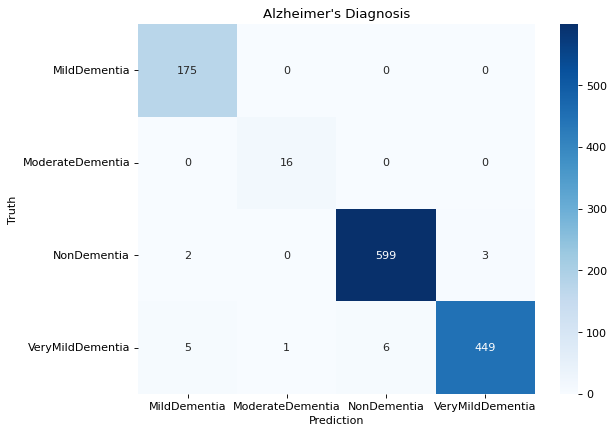

In [37]:
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d',
xticklabels=['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia'],
yticklabels=['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia'])
plt.title('Alzheimer\'s Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)
#plt.savefig("confusion_matrix.png")

In [38]:
class_report = classification_report(labels, predic, target_names=['MildDementia','ModerateDementia', 'NonDementia', 'VeryMildDementia'])
print("Classification Report:\n", class_report)

Classification Report:
                   precision    recall  f1-score   support

    MildDementia       0.96      1.00      0.98       175
ModerateDementia       0.94      1.00      0.97        16
     NonDementia       0.99      0.99      0.99       604
VeryMildDementia       0.99      0.97      0.98       461

        accuracy                           0.99      1256
       macro avg       0.97      0.99      0.98      1256
    weighted avg       0.99      0.99      0.99      1256



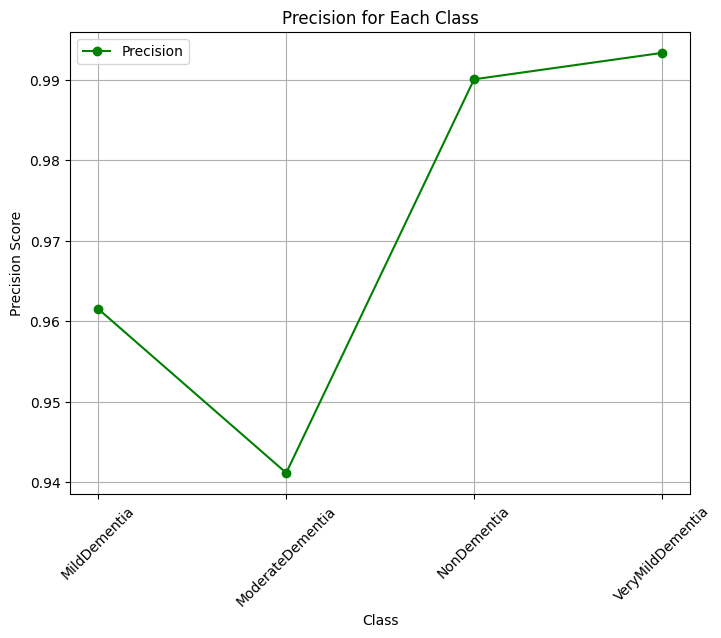

In [39]:
precision = np.diag(conf_arr) / np.sum(conf_arr, axis=0)
recall = np.diag(conf_arr) / np.sum(conf_arr, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)
class_names=['MildDementia', 'ModerateDementia', 'NonDementia','VeryMildDementia']
plt.figure(figsize=(8, 6))
plt.plot(class_names, precision, marker='o', label='Precision', color='green')
plt.title('Precision for Each Class')
plt.xlabel('Class')
plt.ylabel('Precision Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
#plt.savefig("precision_line_plot.png")
plt.show()

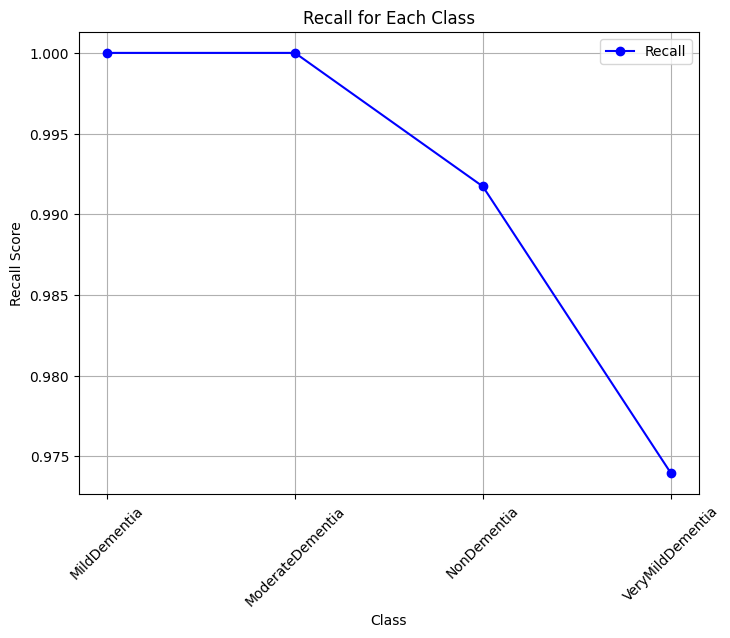

In [40]:
plt.figure(figsize=(8, 6))
plt.plot(class_names, recall, marker='o', label='Recall', color='blue')
plt.title('Recall for Each Class')
plt.xlabel('Class')
plt.ylabel('Recall Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
#plt.savefig("recall_line_plot.png")
plt.show()

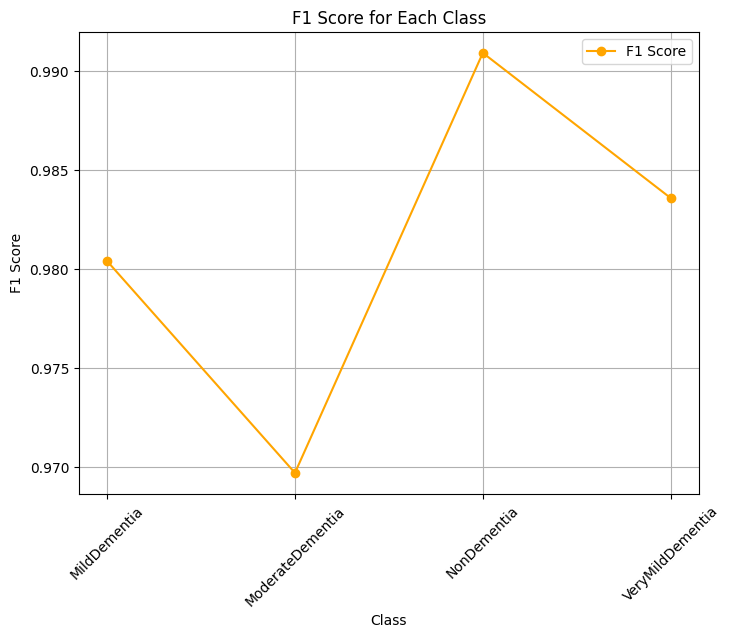

In [41]:
plt.figure(figsize=(8, 6))
plt.plot(class_names, f1_score, marker='o', label='F1 Score', color='orange')
plt.title('F1 Score for Each Class')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
#plt.savefig("f1_score_line_plot.png")
plt.show()

In [42]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [43]:
predic = vg_model.predict(test_data)
labels = label_binarize(np.argmax(test_labels, axis=1), classes=[0, 1, 2, 3])
predic = label_binarize(np.argmax(predic, axis=1), classes=[0, 1, 2, 3])

40/40 ━━━━━━━━━━━━━━━━━━━━ 161s 4s/step


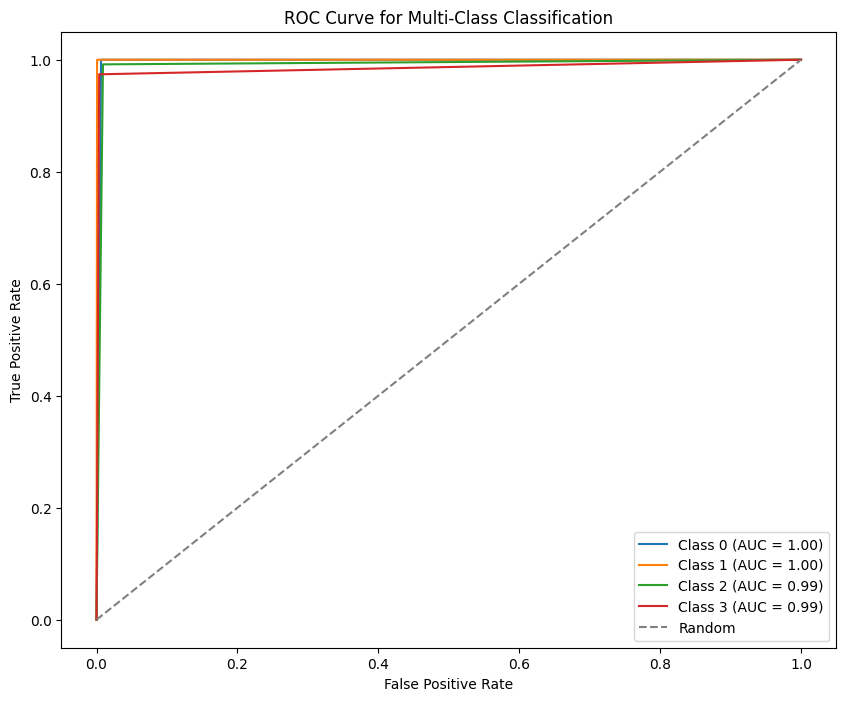

In [44]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(labels.shape[1]):
  fpr[i], tpr[i], _ = roc_curve(labels[:, i], predic[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(10, 8))
for i in range(labels.shape[1]):
  plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.show()

In [45]:
CLASSES = {0: "Mild Dementia", 1: "Moderate Dementia", 2: "Non Dementia", 3:"Very Mild Dementia"}

In [49]:
from tensorflow.keras.preprocessing import image
new_image_path = "test/ModerateDemented/27.jpg"
new_img = image.load_img(new_image_path, target_size=dim)
new_img_array = image.img_to_array(new_img)
new_img_array = np.expand_dims(new_img_array, axis=0)
new_img_array = preprocess_input(new_img_array)
predictions = vg_model.predict(new_img_array)
predicted_class = np.argmax(predictions)
pred_class_label = CLASSES[predicted_class]
print("Predicted class:", pred_class_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Predicted class: Moderate Dementia
